In [1]:
import random, math, time, functools
import copy
from collections import namedtuple, Counter, defaultdict
from enum import Enum

# numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt

# aima
from aima.games import alpha_beta_search, Game, GameState

In [2]:
def play_game(game, strategies: dict, verbose=False):
    """Play a turn-taking game. `strategies` is a {player_name: function} dict,
    where function(state, game) is used to get the player's move."""
    state = game.initial
    while not game.terminal_test(state):
        player = state.to_move
        start = time.time()
        move = strategies[player](game, state)
        end = time.time()
        state = game.result(state, move)
        if verbose: 
            print('Player', player, 'move:', move, 'time: ', end-start, 's.')
            state.display()
    return state

In [3]:
class Tablut(Game):
    def __init__(self, height=9, width=9):
        self.squares = {(x, y) for x in range(width) for y in range(height)}
        self.initial = Board(height=height, width=width, to_move='WHITE', utility=0)

    def actions(self, board):
        """Legal moves are any square not yet taken."""
        # TODO : add legal moves
        return self.squares - set(board)

    def result(self, board, square):
        """Place a marker for current player on square."""
        player = board.to_move
        board = board.new({square: player}, to_move=('BLACK' if player == 'WHITE' else 'WHITE'))
        win = False # TODO : add win condition here
        board.utility = (0 if not win else +1 if player == 'WHITE' else -1)
        return board

    def utility(self, board, player):
        """Return the value to player; 1 for win, -1 for loss, 0 otherwise."""
        return board.utility if player == 'WHITE' else -board.utility

    def terminal_test(self, board):
        """A board is a terminal state if it is won or there are no empty squares."""
        return board.utility != 0 or len(self.squares) == len(board)

    def display(self, board): 
        print(board)

In [4]:
class Pawn(Enum):
    EMPTY = 0
    BLACK = 1
    WHITE = 2
    KING = 3

In [5]:
######## COSTANTS ########
GRAY = (150,150,150)
WHITE = (200,200,200)
WHITE2 = (180,180,180)
RED = (255,0,0)
RED2 = (200,0,0)
GREEN = (0,255,0)
GREEN2 = (0,200,0)
BLUE = (0,0,255)
##########################

In [6]:
class Board(defaultdict):
    empty = Pawn.EMPTY
    off = '#'
    
    def __init__(self, width, height, to_move, **kwds):
        self.__dict__.update(width=width, height=height, to_move=to_move, **kwds)

        self.board = [
            [GRAY, WHITE, WHITE2, RED2, RED, RED2, WHITE2, WHITE, GRAY],
            [WHITE, WHITE2, WHITE, WHITE2, RED2, WHITE2, WHITE, WHITE2, WHITE],
            [WHITE2, WHITE, WHITE2, WHITE, GREEN, WHITE, WHITE2, WHITE, WHITE2],
            [RED2, WHITE2, WHITE, WHITE2, GREEN2, WHITE2, WHITE, WHITE2, RED2],
            [RED, RED2, GREEN, GREEN2, BLUE, GREEN2, GREEN, RED2, RED],
            [RED2, WHITE2, WHITE, WHITE2, GREEN2, WHITE2, WHITE, WHITE2, RED2],
            [WHITE2, WHITE, WHITE2, WHITE, GREEN, WHITE, WHITE2, WHITE, WHITE2],
            [WHITE, WHITE2, WHITE, WHITE2, RED2, WHITE2, WHITE, WHITE2, WHITE],
            [GRAY, WHITE, WHITE2, RED2, RED, RED2, WHITE2, WHITE, GRAY],
        ]
        
        self.pieces = np.array([
        [Pawn.EMPTY, Pawn.EMPTY, Pawn.EMPTY, Pawn.BLACK, Pawn.BLACK, Pawn.BLACK, Pawn.EMPTY, Pawn.EMPTY, Pawn.EMPTY],
        [Pawn.EMPTY, Pawn.EMPTY, Pawn.EMPTY, Pawn.EMPTY, Pawn.BLACK, Pawn.EMPTY, Pawn.EMPTY, Pawn.EMPTY, Pawn.EMPTY],
        [Pawn.EMPTY, Pawn.EMPTY, Pawn.EMPTY, Pawn.EMPTY, Pawn.WHITE, Pawn.EMPTY, Pawn.EMPTY, Pawn.EMPTY, Pawn.EMPTY],
        [Pawn.BLACK, Pawn.EMPTY, Pawn.EMPTY, Pawn.EMPTY, Pawn.WHITE, Pawn.EMPTY, Pawn.EMPTY, Pawn.EMPTY, Pawn.BLACK],
        [Pawn.BLACK, Pawn.BLACK, Pawn.WHITE, Pawn.WHITE, Pawn.KING, Pawn.WHITE, Pawn.WHITE, Pawn.BLACK, Pawn.BLACK],
        [Pawn.BLACK, Pawn.EMPTY, Pawn.EMPTY, Pawn.EMPTY, Pawn.WHITE, Pawn.EMPTY, Pawn.EMPTY, Pawn.EMPTY, Pawn.BLACK],
        [Pawn.EMPTY, Pawn.EMPTY, Pawn.EMPTY, Pawn.EMPTY, Pawn.WHITE, Pawn.EMPTY, Pawn.EMPTY, Pawn.EMPTY, Pawn.EMPTY],
        [Pawn.EMPTY, Pawn.EMPTY, Pawn.EMPTY, Pawn.EMPTY, Pawn.BLACK, Pawn.EMPTY, Pawn.EMPTY, Pawn.EMPTY, Pawn.EMPTY],
        [Pawn.EMPTY, Pawn.EMPTY, Pawn.EMPTY, Pawn.BLACK, Pawn.BLACK, Pawn.BLACK, Pawn.EMPTY, Pawn.EMPTY, Pawn.EMPTY],
        ])

        self.white = np.array([[2, 4],
       [3, 4],
       [4, 2],
       [4, 3],
       [4, 5],
       [4, 6],
       [5, 4],
       [6, 4]])

        self.black = np.array([[0, 3],
       [0, 4],
       [0, 5],
       [1, 4],
       [3, 0],
       [3, 8],
       [4, 0],
       [4, 1],
       [4, 7],
       [4, 8],
       [5, 0],
       [5, 8],
       [7, 4],
       [8, 3],
       [8, 4],
       [8, 5]])

        self.king = np.array([[4, 4]])

    def to_move(self, state):
        return self.__dict__['to_move']
        
    def new(self, changes: dict, **kwds) -> 'Board':
        "Given a dict of {(x, y): contents} changes, return a new Board with the changes."
        board = Board(width=self.width, height=self.height, **kwds)
        board.update(self)
        board.update(changes)

        # Apply changes to the pieces
        keys = np.array(list(changes.keys()))
        values = np.array(list(changes.values()))

        # Update BLACK, WHITE, KING, and EMPTY pieces
        for pawn_type in ['BLACK', 'WHITE', 'KING', 'EMPTY']:
            mask = values == pawn_type
            board.pieces[keys[mask, 1], keys[mask, 0]] = getattr(Pawn, pawn_type)

        return board

    def __missing__(self, loc):
        x, y = loc
        if 0 <= x < self.width and 0 <= y < self.height:
            return self.empty
        else:
            return self.off
            
    def __hash__(self): 
        return hash(tuple(sorted(self.items()))) + hash(self.to_move)

    def display(self):
        """
        Representation of the board using matplotlib
        """
        # Create a new array of integers representing the pieces
        pieces_int = np.vectorize(lambda x: x.value)(self.pieces)

        fig, ax = plt.subplots()
        ax.matshow(pieces_int, cmap="Set3")

        # Changes the size of the pieces
        fontsize = 30

        # Dictionary to map Pawn values to their respective characters and colors
        pawn_dict = {Pawn.BLACK: ("⛂", "black"), Pawn.WHITE: ("⛀", "white"), Pawn.KING: ("⛁", "white")}

        # Places the pieces on the board
        for pawn_value, (char, color) in pawn_dict.items():
            for x, y in np.argwhere(self.pieces == pawn_value):
                ax.text(x, y, char, ha='center', va='center', color=color, fontsize=fontsize)

        plt.box(on=None)
        ax.set_xticks([0,1,2,3,4,5,6,7,8])
        ax.set_yticks([0,1,2,3,4,5,6,7,8])
        ax.set_xticklabels(['A','B','C','D','E','F','G','H','I'])
        ax.set_yticklabels(['1','2','3','4','5','6','7','8','9'])
        plt.show(block=False)
        return fig, ax

In [7]:
def random_player(game, state): 
    return random.choice(list(game.actions(state)))

def player(search_algorithm):
    """A game player who uses the specified search algorithm"""
    return lambda game, state: search_algorithm(game, state)[1]

In [8]:
infinity = float('inf')

def cache(function):
    "Like lru_cache(None), but only considers the first argument of function."
    cache = {}
    def wrapped(x, *args):
        if x not in cache:
            cache[x] = function(x, *args)
        return cache[x]
    return wrapped

def cutoff_depth(d):
    """A cutoff function that searches to depth d."""
    return lambda game, state, depth: depth > d

# TODO change depth (d)
def h_alphabeta_search(game, state, cutoff=cutoff_depth(1), h=lambda s, p: 0):
    """Search game to determine best action; use alpha-beta pruning.
    As in [Figure 5.7], this version searches all the way to the leaves."""

    player = state.to_move

    @cache
    def max_value(state, alpha, beta, depth):
        if game.terminal_test(state):
            return game.utility(state, player), None
        if cutoff(game, state, depth):
            return h(state, player), None
        v, move = -infinity, None
        for a in game.actions(state):
            v2, _ = min_value(game.result(state, a), alpha, beta, depth+1)
            if v2 > v:
                v, move = v2, a
                alpha = max(alpha, v)
            if v >= beta:
                return v, move
        return v, move

    @cache
    def min_value(state, alpha, beta, depth):
        if game.terminal_test(state):
            return game.utility(state, player), None
        if cutoff(game, state, depth):
            return h(state, player), None
        v, move = +infinity, None
        for a in game.actions(state):
            v2, _ = max_value(game.result(state, a), alpha, beta, depth + 1)
            if v2 < v:
                v, move = v2, a
                beta = min(beta, v)
            if v <= alpha:
                return v, move
        return v, move

    return max_value(state, -infinity, +infinity, 0)

Player WHITE move: (4, 0) time:  0.09756135940551758 s.


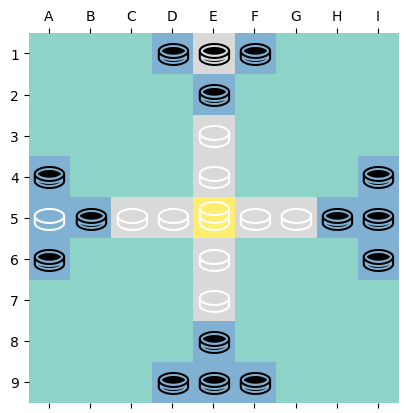

Player BLACK move: (3, 7) time:  0.06613826751708984 s.


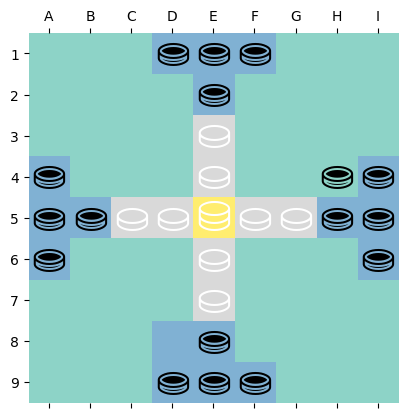

Player WHITE move: (5, 4) time:  0.07636022567749023 s.


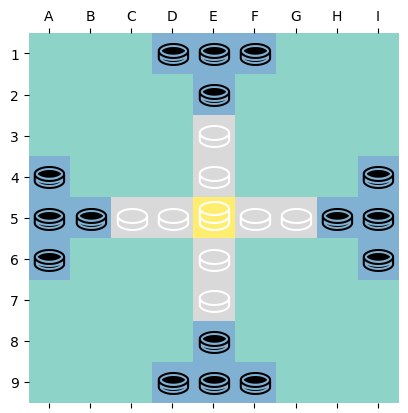

Player BLACK move: (4, 6) time:  0.06830978393554688 s.


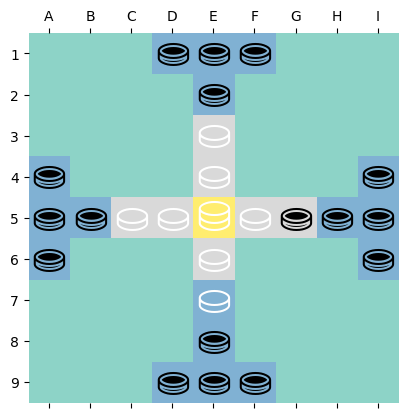

Player WHITE move: (5, 1) time:  0.058820247650146484 s.


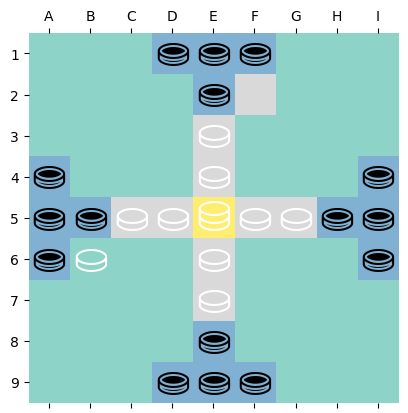

Player BLACK move: (8, 0) time:  0.06670165061950684 s.


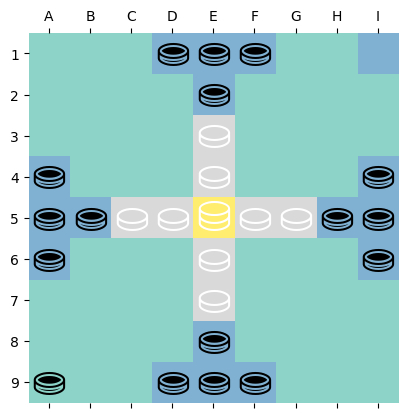

Player WHITE move: (0, 5) time:  0.08374810218811035 s.


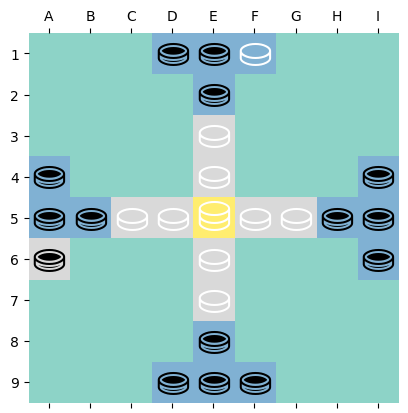

Player BLACK move: (2, 2) time:  0.06856250762939453 s.


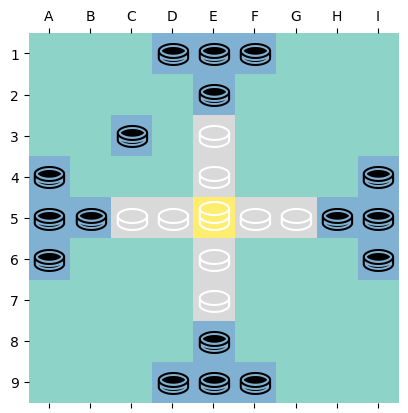

Player WHITE move: (8, 6) time:  0.08569216728210449 s.


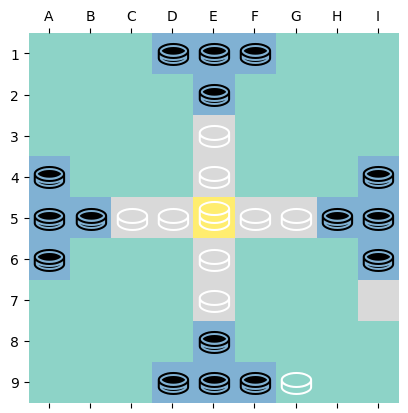

Player BLACK move: (1, 0) time:  0.059651851654052734 s.


KeyboardInterrupt: 

In [9]:
%%time
play_game(Tablut(), dict(WHITE=player(h_alphabeta_search), BLACK=player(h_alphabeta_search)), verbose=True).utility